In [891]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Configuraciones
%matplotlib inline
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.1)

### Funciones Helper
Aquí se encuentran las funciones auxiliares utilizadas en este notebook. Estas funciones permiten realizar tareas específicas de manera más ordenada y modular.

In [892]:
def introduce_nulls(df, percentage):
    """
    Introduce valores nulos aleatorios en un DataFrame hasta alcanzar un porcentaje deseado.

    :param df: DataFrame original al que se introducirán valores nulos.
    :param percentage: Porcentaje de valores nulos a introducir, entre 0 y 1.
    :return: DataFrame con valores nulos introducidos.
    """

    df = df.copy()
    total_cells = df.size
    current_nulls = df.isnull().sum().sum()
    target_nulls = int(total_cells * percentage)
    additional_nulls = max(0, target_nulls - current_nulls)

    if additional_nulls == 0: return df

    for _ in range(additional_nulls):
        row = np.random.randint(0, df.shape[0])
        col = np.random.randint(0, df.shape[1])
        df.iat[row, col] = np.nan

    return df


def introduce_invalid_values(df, categorical_cols, invalid_values, percentage):
    """
    Introduce valores inválidos aleatorios en columnas categóricas de un DataFrame.

    :param df: DataFrame original al que se introducirán valores inválidos.
    :param categorical_cols: Lista de nombres de columnas categóricas en las que introducir valores inválidos.
    :param invalid_values: Lista de valores inválidos que se usarán para reemplazar valores existentes.
    :param percentage: Porcentaje de valores inválidos a introducir, entre 0 y 1.
    :return: DataFrame con valores inválidos intrducidos en las columnas categóricas especificadas.
    """

    df = df.copy()
    total_cells = sum(df[col].notnull().sum() for col in categorical_cols)
    target_invalids = int(total_cells * percentage)

    for _ in range(target_invalids):
        col = np.random.choice(categorical_cols)
        valid_indices = df[df[col].notnull()].index
        if len(valid_indices) == 0: continue
        row = np.random.choice(valid_indices)
        invalid_value = np.random.choice(invalid_values)
        df.at[row, col] = invalid_value

    return df


def filter_outliers_iqr(df, column):
    """
    Filtra los valores de una columna de un DataFrame eliminando los outliers según el método del rango intercuartílico.

    :param df: DataFrame original.
    :param column: Nombre de la columna donde se eliminarán los outliers.
    :return: DataFrame filtrado, sin los outliers en la columna especificada.
    """

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]


### Paso 1: Cargar el dataset y explorar estadísticas descriptivas
1. **Cargar el dataset**:
   - Importar el dataset `tips` e introducir valores nulos e inválidos de forma aleatoria para simular escenarios reales con datos faltantes o erróneos.
2. **Explorar los datos**:
   - Visualizar las 5 primeras y últimas filas del dataset.
   - Obtener información general, incluyendo tipos de datos, valores no nulos y memoria utilizada.
3. **Calcular estadísticas descriptivas**:
   - Resumen de columnas numéricas y categóricas.
   - Frecuencia de valores únicos en columnas categóricas (`sex`, `smoker`, `day`, `time`).
4. **Visualizar los datos**:
   - **Histograma**: Distribución de `total_bill`.
   - **Gráfico de barras**: Frecuencia de valores en `day`.

In [893]:
# Cargar el dataset
tips = pd.read_csv('data/tips.csv')

# Nota: Introducir valores nulos e inválidos genera "ruido" en el dataset,
# lo que puede dificultar que los modelos identifiquen patrones y reducir su rendimiento.
# Este paso se realiza únicamente con fines prácticos para demostrar técnicas de limpieza de datos.
# Si se desea se pueden comentar las siguientes líneas para preservar los datos originales.
tips = introduce_nulls(tips, percentage=0.1)
tips = introduce_invalid_values(tips, ['sex', 'smoker', 'day', 'time'], ['Invalid', 'Unknown', '123', None],
                                percentage=0.1)

In [894]:
# Mostrar las 5 primeras filas
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0
1,10.34,1.66,123,No,Sun,Invalid,3.0
2,21.01,3.50,Male,NaN,Sun,Dinner,3.0
3,23.68,NaN,Male,No,Sun,Dinner,2.0
4,24.59,3.61,Female,No,Sun,Dinner,4.0


In [895]:
# Mostrar las 5 últimas filas
tips.tail(5)

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,123,No,Invalid,Dinner,3.0
240,27.18,2.00,Female,Yes,Invalid,Dinner,2.0
241,22.67,2.00,Male,Yes,Sat,Dinner,2.0
242,17.82,NaN,Male,NaN,Sat,Dinner,2.0
243,18.78,3.00,Female,No,Thur,Unknown,2.0


In [896]:
# Resumen del DataFrame tips mostrando el número de columnas, tipos de datos, valores no nulos y memoria utilizada
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  222 non-null    float64
 1   tip         216 non-null    float64
 2   sex         220 non-null    object 
 3   smoker      205 non-null    object 
 4   day         226 non-null    object 
 5   time        212 non-null    object 
 6   size        222 non-null    float64
dtypes: float64(3), object(4)
memory usage: 13.5+ KB


In [897]:
# Estadísticas descriptivas numéricas
tips.describe()

,total_bill,tip,size
count,222.000000,216.000000,222.000000
mean,19.823468,3.013148,2.581081
std,8.935054,1.413629,0.970237
min,3.070000,1.000000,1.000000
25%,13.302500,2.000000,2.000000
50%,17.795000,2.855000,2.000000
75%,24.222500,3.602500,3.000000
max,50.810000,10.000000,6.000000


In [898]:
# Estadísticas descriptivas categóricas.
tips.describe(include=['object', 'category'])

,sex,smoker,day,time
count,220,205,226,212
unique,5,5,7,5
top,Male,No,Sat,Dinner
freq,126,124,74,144


In [899]:
# Frecuencia de valores categóricos
for col in ['sex', 'smoker', 'day', 'time']:
    print(f"\nFrecuencia de {col}:")
    print(tips[col].value_counts())


Frecuencia de sex:
sex
Male       126
Female      77
123         10
Unknown      4
Invalid      3
Name: count, dtype: int64

Frecuencia de smoker:
smoker
No         124
Yes         65
Unknown      8
123          5
Invalid      3
Name: count, dtype: int64

Frecuencia de day:
day
Sat        74
Sun        67
Thur       56
Fri        15
Invalid     6
Unknown     4
123         4
Name: count, dtype: int64

Frecuencia de time:
time
Dinner     144
Lunch       52
Unknown      8
Invalid      4
123          4
Name: count, dtype: int64


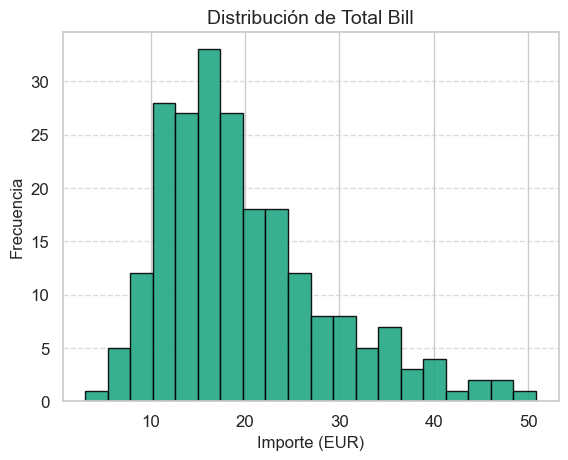

In [900]:
# Histograma que muestra la distribución de los valores en la columna total_bill
plt.hist(tips['total_bill'], bins=20, color=plt.cm.viridis(0.6), edgecolor='black', alpha=0.9)
plt.title('Distribución de Total Bill', fontsize=14)
plt.xlabel('Importe (EUR)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

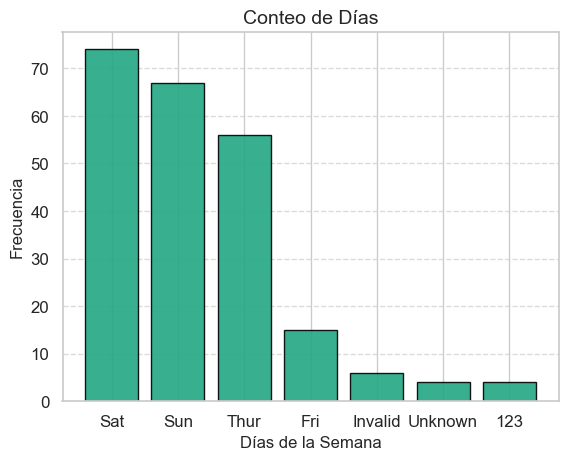

In [901]:
# Gráfico de barras que muestra la frecuencia de las categorías en la columna day
plt.bar(tips['day'].value_counts().index, tips['day'].value_counts().values, color=plt.cm.viridis(0.6),
        edgecolor='black', alpha=0.9)
plt.title('Conteo de Días', fontsize=14)
plt.xlabel('Días de la Semana', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Paso 2: Limpieza y corrección de datos
1. **Detectar valores nulos**:
   - Identificar si hay valores nulos en el dataset.
   - Determinar una estrategia para corregirlos (eliminarlos, imputarlos, etc.).
2. **Corrección de tipos de datos**:
   - Verificar si los tipos de datos son correctos para cada columna.
   - Corregirlos si es necesario.
3. **Eliminación de duplicados**:
   - Identificar y eliminar filas duplicadas.
4. **Identificar y tratar Outliers**:
   - Detectar valores atípicos en las columnas numéricas.
   - Decidir cómo tratarlos (eliminarlos, ajustarlos, etc.).

In [902]:
# Detección de valores nulos
print("Valores nulos por columna:")
print(tips.isnull().sum())

Valores nulos por columna:
total_bill    22
tip           28
sex           24
smoker        39
day           18
time          32
size          22
dtype: int64


In [903]:
# Eliminar columnas con un alto porcentaje de nulos
threshold = 0.5
null_percent = tips.isnull().mean()
cols_to_drop = null_percent[null_percent > threshold].index
tips = tips.drop(columns=cols_to_drop)
print(f"Columnas eliminadas por tener más del {threshold * 100}% de valores nulos:")
print(cols_to_drop)

Columnas eliminadas por tener más del 50.0% de valores nulos:
Index([], dtype='object')


In [904]:
# Imputar valores nulos para columnas numéricas con la media
numeric_cols = tips.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    tips[col] = tips[col].fillna(tips[col].mean())

# Imputar valores nulos para columnas categóricas con la moda
categorical_cols = tips.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if tips[col].isnull().any():
        tips[col] = tips[col].fillna(tips[col].mode()[0])

print("\nValores nulos después de la imputación:")
print(tips.isnull().sum())


Valores nulos después de la imputación:
total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64


In [905]:
# Corregir columnas numéricas mal tipadas
numeric_cols = ['total_bill', 'tip', 'size']

for col in numeric_cols:
    tips[col] = pd.to_numeric(tips[col], errors='coerce')  # Nota: to_numeric ya trata de hacer el casting desde string
    tips[col] = tips[col].fillna(tips[col].median())

# Corregir columnas categóricas
categorical_cols = ['sex', 'smoker', 'day', 'time']

valid_values = {
    'smoker': {'Yes', 'No'},
    'sex': {'Male', 'Female'},
    'day': {'Thur', 'Fri', 'Sat', 'Sun'},
    'time': {'Lunch', 'Dinner'}
}

for col in categorical_cols:
    tips[col] = tips[col].apply(lambda x: x if x in valid_values[col] else 'Unknown')
    tips[col] = tips[col].astype('category')

# Validar correcciones
print("Tipos de datos después de la corrección:")
tips.info()

print("\nValores únicos después de la corrección:")
for col in categorical_cols:
    print(f"{col}: {tips[col].unique()}")


Tipos de datos después de la corrección:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    float64 
dtypes: category(4), float64(3)
memory usage: 7.4 KB

Valores únicos después de la corrección:
sex: ['Female', 'Unknown', 'Male']
Categories (3, object): ['Female', 'Male', 'Unknown']
smoker: ['No', 'Unknown', 'Yes']
Categories (3, object): ['No', 'Unknown', 'Yes']
day: ['Sun', 'Unknown', 'Sat', 'Thur', 'Fri']
Categories (5, object): ['Fri', 'Sat', 'Sun', 'Thur', 'Unknown']
time: ['Dinner', 'Unknown', 'Lunch']
Categories (3, object): ['Dinner', 'Lunch', 'Unknown']


In [906]:
# Identificar y eliminar filas duplicadas
duplicates = tips.duplicated()
num_duplicates = duplicates.sum()
print(f"Número total de filas duplicadas: {num_duplicates}")

if num_duplicates > 0:
    print("\nFilas duplicadas encontradas:")
    print(tips[duplicates])
    # No elimino las filas duplicadas del dataset original porque podrían ser casos válidos (por ejemplo diferentes mesas con facturas idénticas)
    # Si fuera necesario se pueden eliminar con -> tips.drop_duplicates():
    tips_no_duplicates = tips.drop_duplicates()
    print(f"Tamaño del dataset después de eliminar duplicados: {tips_no_duplicates.shape}")
else:
    print("No se encontraron filas duplicadas en el dataset.")


Número total de filas duplicadas: 1

Filas duplicadas encontradas:
    total_bill       tip   sex smoker  day    time  size
60   19.823468  3.013148  Male    Yes  Sat  Dinner   2.0
Tamaño del dataset después de eliminar duplicados: (243, 7)


Tamaño del dataset original: (244, 7)
Tamaño del dataset sin outliers en total_bill: (233, 7)
Tamaño del dataset sin outliers en tip: (234, 7)


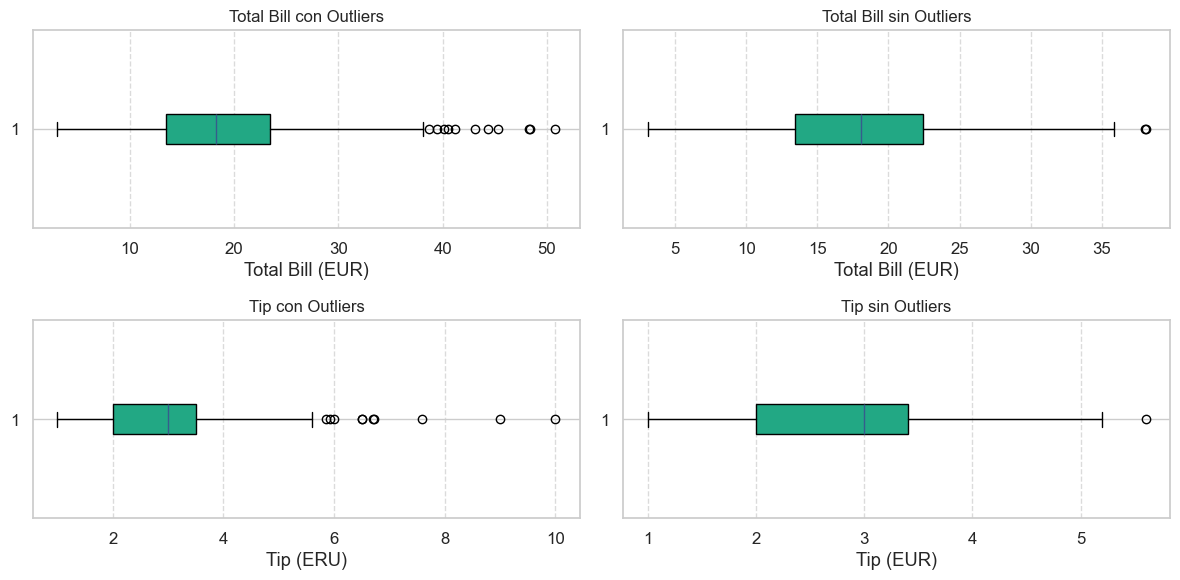

In [907]:
# Identificar, tratar y visualizar outliers en las columnas total_bill y tip

# Filtrar outliers en total_bill y tip
tips_with_no_outliers_total_bill = filter_outliers_iqr(tips, 'total_bill')
tips_with_no_outliers_tip = filter_outliers_iqr(tips, 'tip')

# Imprimir el tamaño de los datasets
print("Tamaño del dataset original:", tips.shape)
print("Tamaño del dataset sin outliers en total_bill:", tips_with_no_outliers_total_bill.shape)
print("Tamaño del dataset sin outliers en tip:", tips_with_no_outliers_tip.shape)

# Visualizar boxplots para total_bill y tip
plt.figure(figsize=(12, 6))

# Boxplot de total_bill original
plt.subplot(2, 2, 1)
plt.boxplot(tips['total_bill'], vert=False, patch_artist=True, boxprops=dict(facecolor=plt.cm.viridis(0.6)))
plt.title('Total Bill con Outliers', fontsize=12)
plt.xlabel('Total Bill (EUR)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Boxplot de total_bill sin outliers
plt.subplot(2, 2, 2)
plt.boxplot(tips_with_no_outliers_total_bill['total_bill'], vert=False, patch_artist=True,
            boxprops=dict(facecolor=plt.cm.viridis(0.6)))
plt.title('Total Bill sin Outliers', fontsize=12)
plt.xlabel('Total Bill (EUR)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Boxplot de tip original
plt.subplot(2, 2, 3)
plt.boxplot(tips['tip'], vert=False, patch_artist=True, boxprops=dict(facecolor=plt.cm.viridis(0.6)))
plt.title('Tip con Outliers', fontsize=12)
plt.xlabel('Tip (ERU)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Boxplot de tip sin outliers
plt.subplot(2, 2, 4)
plt.boxplot(tips_with_no_outliers_tip['tip'], vert=False, patch_artist=True, boxprops=dict(facecolor=plt.cm.viridis(0.6)))
plt.title('Tip sin Outliers', fontsize=12)
plt.xlabel('Tip (EUR)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

### Paso 3: Análisis Exploratorio de Datos (EDAS) con Seaborn
1. **Visualizaciones univariantes**:
   - Analizar la distribución de variables individuales, como:
     - **Histogramas**: Para columnas numéricas (`total_bill`, `tip`).
     - **Boxplots**: Para identificar valores extremos para las columnas (`total_bill`, `tip`).
     - **Gráficos de barras**: Para frecuencias en columnas categóricas (`day`, `sex`, `time`).
2. **Visualizaciones bivariantes**:
   - Examinar relaciones entre dos variables, como:
     - **Scatterplots**: Relación entre `total_bill` y `tip`.
     - **Boxplots**: Comparar distribuciones de `total_bill` por `day` o `smoker`.
     - **Heatmaps**: Correlación entre variables numéricas.
3. **Visualizaciones multivariantes**:
   - Explorar patrones consierando varias variables simultáneamente:
     - **Pairplots**: Relaciones entre variables numéricas (`total_bill`, `tip`, `size`).
     - **Violinplots**: Distribución de `tip` según combinaciones de `day` y `smoker`.

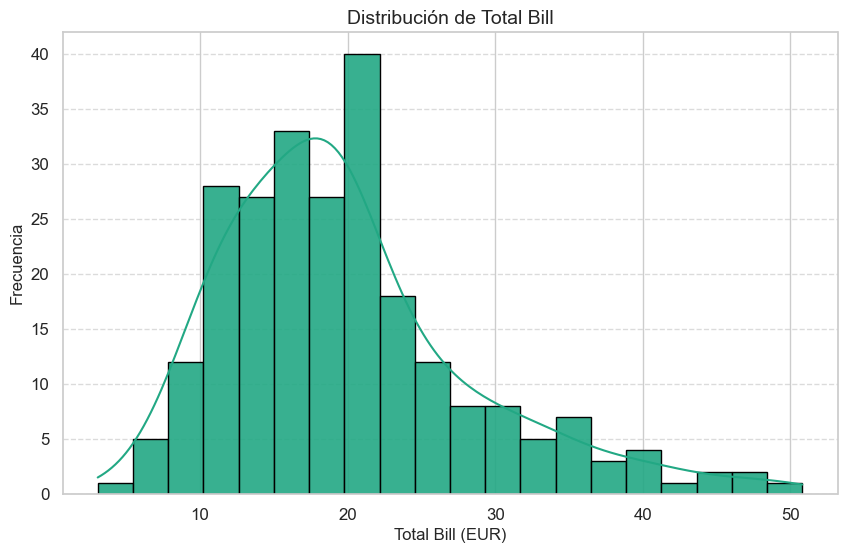

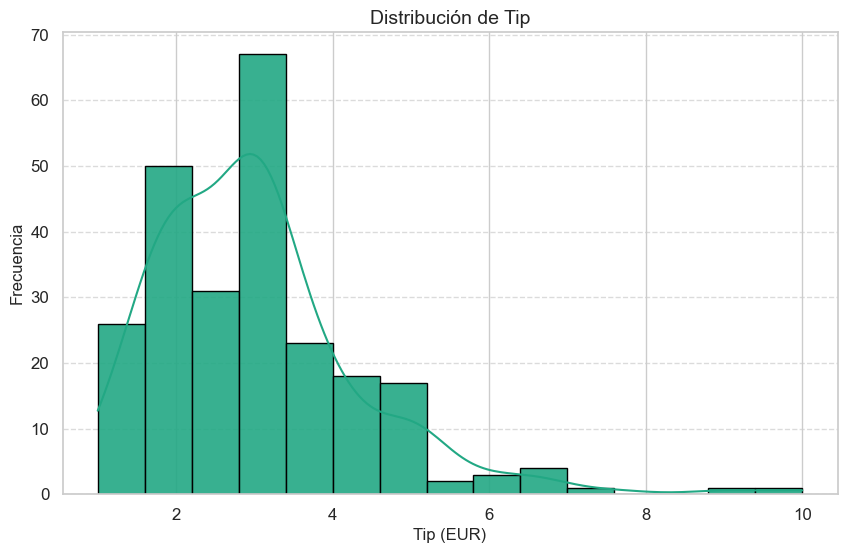

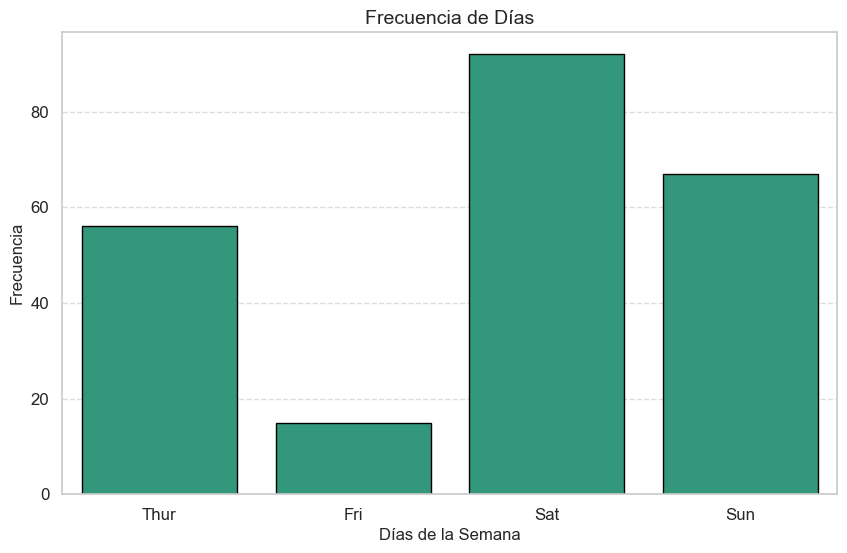

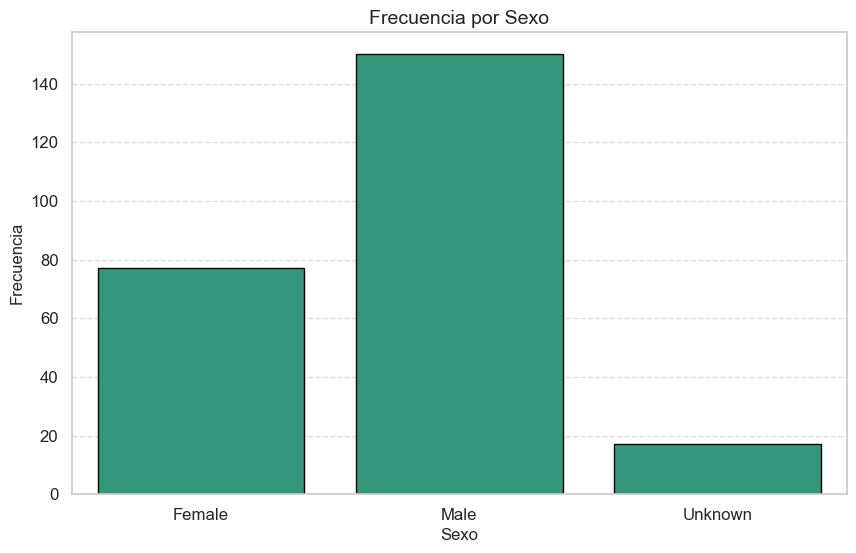

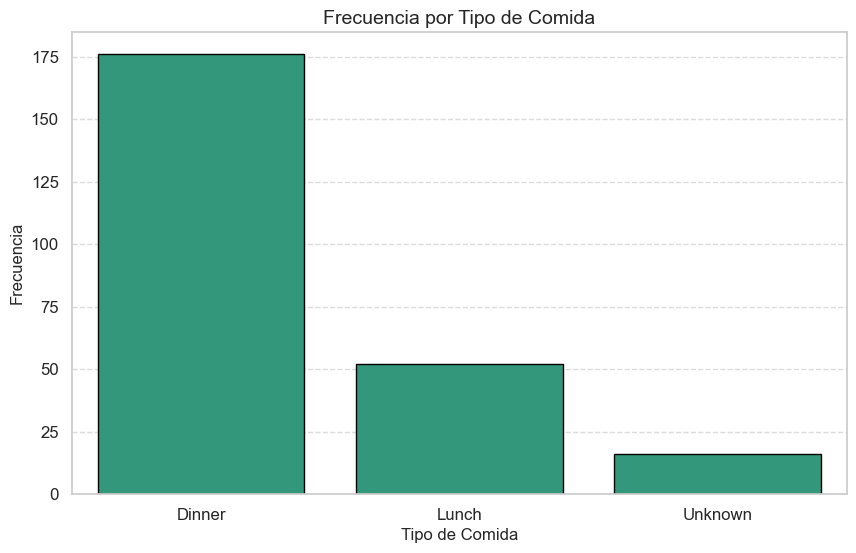

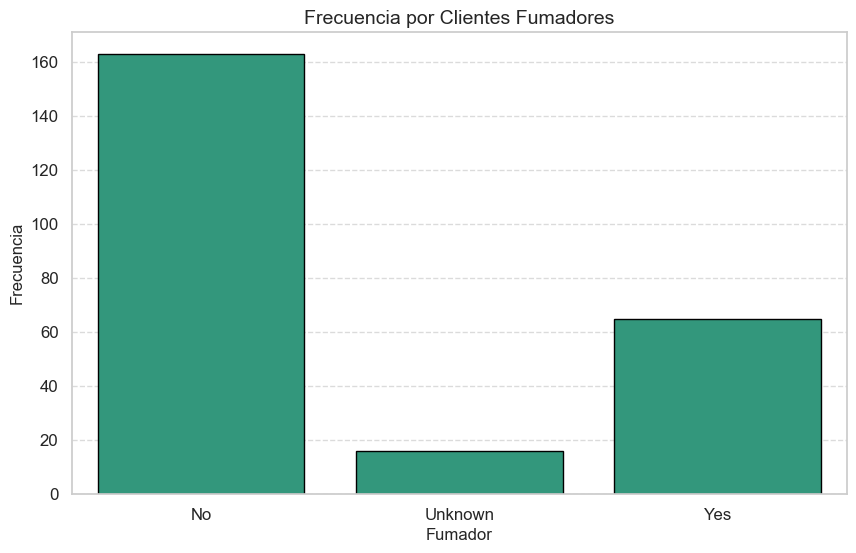

In [908]:
# UNIVARIANTES

# Histograma de total_bill
plt.figure(figsize=(10, 6))
sns.histplot(tips['total_bill'], kde=True, bins=20, color=plt.cm.viridis(0.6), edgecolor='black', alpha=0.9)
plt.title('Distribución de Total Bill', fontsize=14)
plt.xlabel('Total Bill (EUR)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Histograma de tip
plt.figure(figsize=(10, 6))
sns.histplot(tips['tip'], kde=True, bins=15, color=plt.cm.viridis(0.6), edgecolor='black', alpha=0.9)
plt.title('Distribución de Tip', fontsize=14)
plt.xlabel('Tip (EUR)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras para day
plt.figure(figsize=(10, 6))
sns.countplot(x='day', data=tips, color=plt.cm.viridis(0.6), order=['Thur', 'Fri', 'Sat', 'Sun'], edgecolor='black')
plt.title('Frecuencia de Días', fontsize=14)
plt.xlabel('Días de la Semana', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras para sex
plt.figure(figsize=(10, 6))
sns.countplot(x='sex', data=tips, color=plt.cm.viridis(0.6), edgecolor='black')
plt.title('Frecuencia por Sexo', fontsize=14)
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras para time
plt.figure(figsize=(10, 6))
sns.countplot(x='time', data=tips, color=plt.cm.viridis(0.6), edgecolor='black')
plt.title('Frecuencia por Tipo de Comida', fontsize=14)
plt.xlabel('Tipo de Comida', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras para smoker
plt.figure(figsize=(10, 6))
sns.countplot(x='smoker', data=tips, color=plt.cm.viridis(0.6), edgecolor='black')
plt.title('Frecuencia por Clientes Fumadores', fontsize=14)
plt.xlabel('Fumador', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

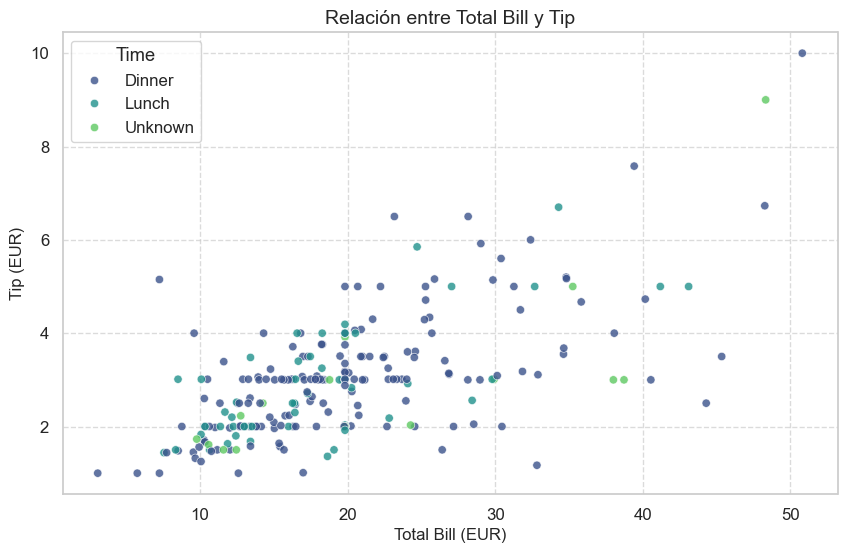

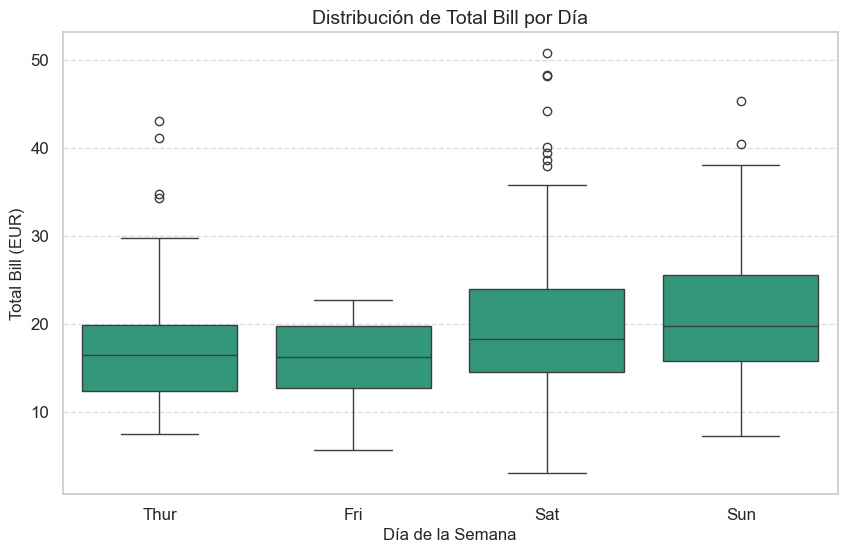

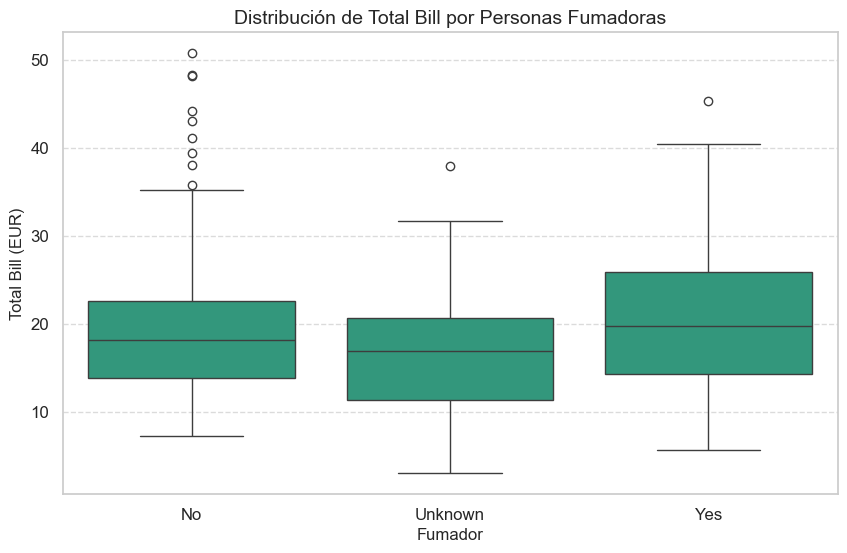

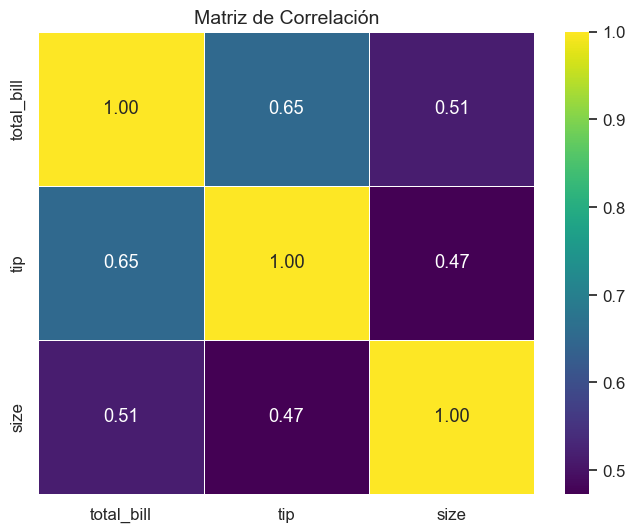

In [909]:
# BIVARIANTES

# Scatterplot: Relación entre total_bill y tip
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_bill', y='tip', data=tips, hue='time', palette='viridis', alpha=0.8)
plt.title('Relación entre Total Bill y Tip', fontsize=14)
plt.xlabel('Total Bill (EUR)', fontsize=12)
plt.ylabel('Tip (EUR)', fontsize=12)
plt.legend(title='Time', loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Boxplot: Distribución de total_bill por day
plt.figure(figsize=(10, 6))
sns.boxplot(x='day', y='total_bill', data=tips, color=plt.cm.viridis(0.6), order=['Thur', 'Fri', 'Sat', 'Sun'])
plt.title('Distribución de Total Bill por Día', fontsize=14)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Total Bill (EUR)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Boxplot: Distribución de total_bill por smoker
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='total_bill', data=tips, color=plt.cm.viridis(0.6))
plt.title('Distribución de Total Bill por Personas Fumadoras', fontsize=14)
plt.xlabel('Fumador', fontsize=12)
plt.ylabel('Total Bill (EUR)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Heatmap: Matriz de correlación entre variables numéricas
plt.figure(figsize=(8, 6))
correlation_matrix = tips.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación', fontsize=14)
plt.show()

<Figure size 1000x600 with 0 Axes>

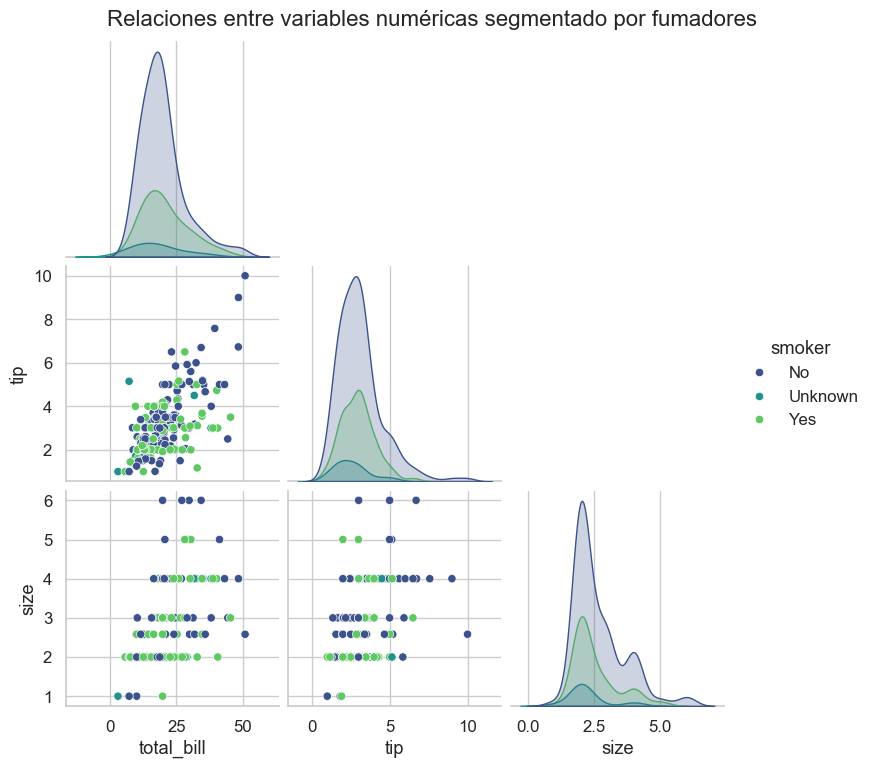

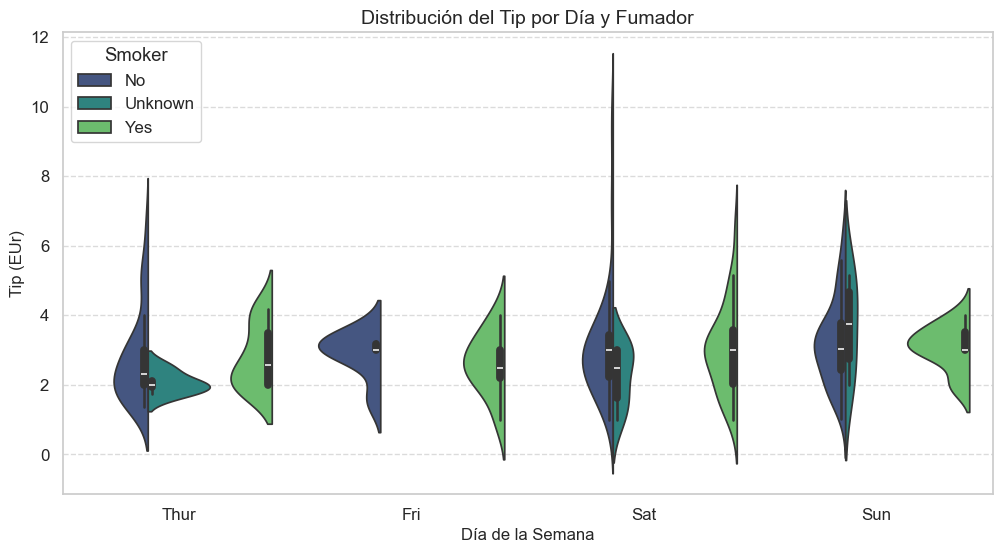

In [910]:
# MULTIVARIANTES

# Pairplot: Relaciones entre variables numéricas total_bill, tip y size segmentadas por smoker
plt.figure(figsize=(10, 6))
sns.pairplot(tips[['total_bill', 'tip', 'size', 'smoker']], hue='smoker', palette='viridis', diag_kind='kde',
             corner=True)
plt.suptitle('Relaciones entre variables numéricas segmentado por fumadores', y=1.02, fontsize=16)
plt.show()

# Violinplot: Distribución de tip según day y smoker
plt.figure(figsize=(12, 6))
sns.violinplot(x='day', y='tip', hue='smoker', data=tips, split=True, palette='viridis',
               order=['Thur', 'Fri', 'Sat', 'Sun'])
plt.title('Distribución del Tip por Día y Fumador', fontsize=14)
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Tip (EUr)', fontsize=12)
plt.legend(title='Smoker', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Paso 4: Preparación de datos para el modelado
1. **Codificación de variables categóricas**:
   - Convertir las columnas categóricas en variables numéricas utilizando la función `get_dummies` de Pandas.
   - Usar el argumento `drop_first=True` para evitar multicolinealidad.
2. **Escalado de columnas numéricas**:
   - Normalizar las columnas numéricas (`total_bill` y `size`) utilizando `StandardScaler` de Scikit-learn.
   - Esto asegura que los valores estén en la misma escala y facilita el entrenamiento de modelos.
3. **Análisis de correlación**:
   - Calcular la matriz de correlación para identificar las columnas más relevantes para predecir la variable target `tip`.
   - Seleccionar únicamente las columnas con mayor correlación con `tip`:
     - **`total_bill`**
     - **`size`**
4. **Particionamiento de los datos**:
   - Dividir el dataset en conjuntos de **entrenamiento** (80%) y **prueba** (20%) utilizando la función `train_test_split` de Scikit-learn.

In [911]:
# Codificar variables categóricas
tips_dummies = pd.get_dummies(tips, columns=['sex', 'smoker', 'day', 'time'], drop_first=True)
print("\nDataset después de codificar variables categóricas:")
tips_dummies.head()


Dataset después de codificar variables categóricas:


,total_bill,tip,size,sex_Male,sex_Unknown,smoker_Unknown,smoker_Yes,day_Sat,day_Sun,day_Thur,day_Unknown,time_Lunch,time_Unknown
0,16.99,1.010000,2.0,False,False,False,False,False,True,False,False,False,False
1,10.34,1.660000,3.0,False,True,False,False,False,True,False,False,False,True
2,21.01,3.500000,3.0,True,False,False,False,False,True,False,False,False,False
3,23.68,3.013148,2.0,True,False,False,False,False,True,False,False,False,False
4,24.59,3.610000,4.0,False,False,False,False,False,True,False,False,False,False


In [912]:
# Normalizar las columnas numéricas a igual escala
numeric_cols = ['total_bill', 'size']
scaler = StandardScaler()
tips_dummies[numeric_cols] = scaler.fit_transform(tips_dummies[numeric_cols])
print("\nDataset después de escalar columnas numéricas:")
tips_dummies[numeric_cols].head()


Dataset después de escalar columnas numéricas:


,total_bill,size
0,-0.333211,-0.629300
1,-1.115241,0.453681
2,0.139534,0.453681
3,0.453522,-0.629300
4,0.560537,1.536663


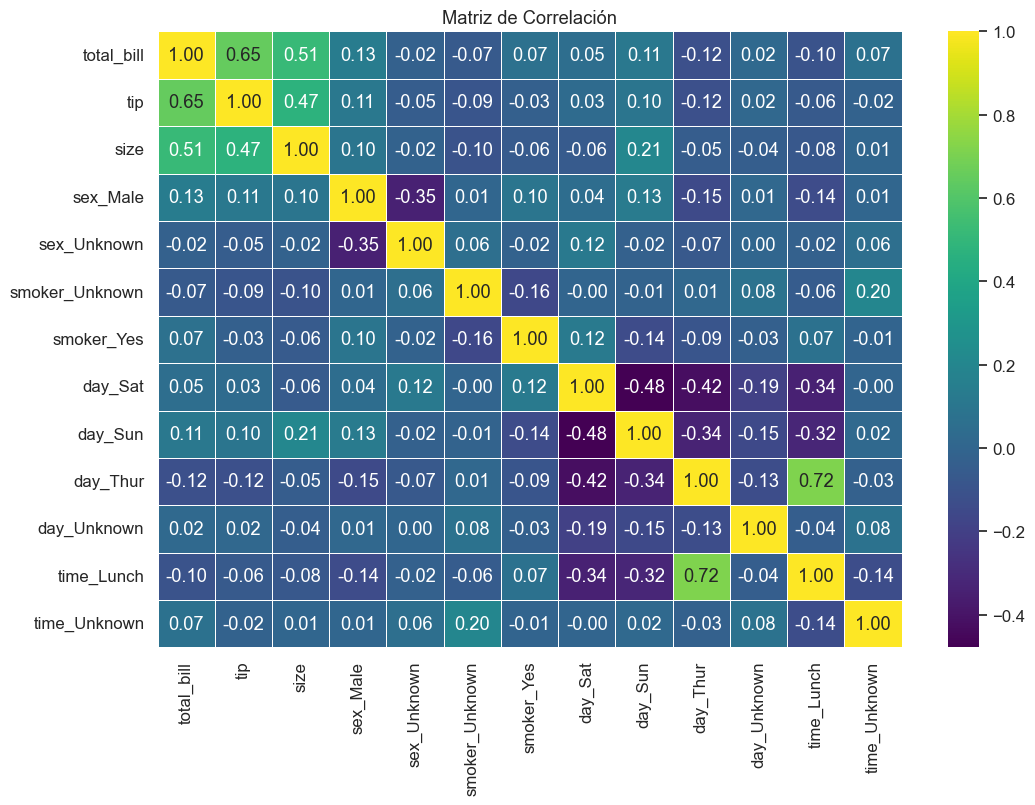

In [913]:
# Análisis de correlación
plt.figure(figsize=(12, 8))
correlation_matrix = tips_dummies.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [914]:
# Selecciono 'total_bill' y 'size' (X) porque tienen las correlaciones más altas con 'tip' (y).
X = tips_dummies[['total_bill', 'size']]
y = tips_dummies['tip']

# Particionamiento de los datos en entrenamiento y prueba.
# Nota: El parámetro 'random_state' permite que la división de los datos siempre sea igual al ejecutar el código.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Paso 5: Modelado
1. **Definición del objetivo**:
   - Probar diferentes modelos de regresión de Scikit-learn para predecir la columna `tip` a partir de las variables seleccionadas (`total_bill` y `size`).
2. **Modelos de regresión a probar**:
   - **Regresión Lineal**
   - **KNN k = 3**
   - **KNN k = 5**
   - **Árbol de Decisió 5**
   - **Random Forest 100**
   - **SVR C = 10**
3. **Métricas de evaluación**:
   - **MAE (Mean Absolute Error)**
   - **RMSE (Root Mean Squared Error)**
   - **R2 (Coeficiente de determinación)**
4. **Flujo del modelado**:
   - Entrenar los modelos en el conjunto de entrenamiento (`X_train`, `y_train`).
   - Evaluar el rendimiento en el conjunto de prueba (`X_test`, `y_test`).
5. **Objetivo**:
   - Identificar el modelo con el mejor rendimiento para la predicción de `tip` analizando las métricas obtenidas.

In [915]:
# Diccionario con todos los modelos a probar
models = {
    'Regresión Lineal': LinearRegression(),
    'KNN k = 3': KNeighborsRegressor(n_neighbors=3),
    'KNN k = 5': KNeighborsRegressor(n_neighbors=5),
    'Árbol de Decisión depth = 5': DecisionTreeRegressor(max_depth=5),
    'Random Forest 100': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR C = 1': SVR(C=1)
}

# DataFrame para almacenar resultados
results = pd.DataFrame(columns=['Modelo', 'R2', 'MAE', 'RMSE', 'MAPE'])

# Probar cada modelo y almacenar los resultados
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    results.loc[len(results)] = [name, r2, mae, rmse, mape]

# Ordenar los resultados por R2
results = results.sort_values(by='R2', ascending=False)

# Mostrar los resultados ordenados de mejor a peor
print(results)

                        Modelo        R2       MAE      RMSE       MAPE
5                    SVR C = 1  0.511831  0.585604  0.766090  24.861512
0             Regresión Lineal  0.507477  0.624560  0.769499  25.995371
1                    KNN k = 3  0.380772  0.697457  0.862820  32.140768
2                    KNN k = 5  0.359912  0.694620  0.877232  31.425817
4            Random Forest 100  0.298102  0.722267  0.918611  33.212732
3  Árbol de Decisión depth = 5 -0.116085  0.803041  1.158359  37.010118
